In [1]:
%%html 
<link href="https://fonts.googleapis.com/css?family=Open+Sans" rel="stylesheet">
<style>#notebook-container{font-size: 13pt;font-family:'Open Sans', sans-serif;} div.text_cell{max-width: 104ex;}</style>

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd

# Probability Analysis of Monopoly

In this document we are going to analyze the probabilities in Monopoly to answer the question: which are the best houses to buy?

To answer this question we will create a simulated version of Monopoly and determine the probabilities to land on each square. Then we calculate the expected value for each square. The squares with the highest expected values are the best squares to have.

![monopoly](monopoly_1.jpg)

## Squares

Each edge has 9 positions and there are 4 edges. There are 4 corners. Which gives a total of 40 positions where a player can land. The labels are numbered starting at GO.

### Labels

In [4]:
squares_labels = ['start', 'b1', 'cc1', 'b2', 'it', 't1', 
                  'lb1', 'c1', 'lb2', 'lb3', 'jail', 'p1', 
                  'ec', 'p2', 'p3', 'ts2', 'o1', 'cc2', 
                  'o2', 'o3', 'p', 'r1', 'c2', 'r2', 'r3', 
                  'ts3', 'y1', 'y2', 'ww', 'y3', 'gtj', 
                  'g1', 'g2', 'cc3', 'g3', 'ts4', 'c3', 
                  'db1', 'st', 'db2']

squares_total = len(squares_labels)
print('There are {} squares.'.format(squares_total))

There are 40 squares.


### Descriptions

We also want to know the proper names, so we don't have to look up the labels.

In [5]:
squares_description = ['Start', 'Brown 1', 'Community Chest 1', 'Brown 2', 
                       'Income Tax', 'Train Station 1', 'Light Blue 1', 
                       'Chance 1', 'Light Blue 2', 'Light Blue 3', 'Jail', 
                       'Purple 1', 'Electric Company', 'Purple 2', 
                       'Purple 3', 'Train Station 2', 'Orange 1', 
                       'Community Chest 2', 'Orange 2', 'Orange 3', 
                       'Free Parking', 'Red 1', 'Chance 2', 'Red 2', 
                       'Red 3', 'Train Station 3', 'Yellow 1', 'Yellow 2', 
                       'Water Works', 'Yellow 3', 'Go to Jail', 'Green 1', 
                       'Green 2', 'Community Chest 3', 'Green 3', 
                       'Train Station 4', 'Chance 3', 'Dark Blue 1', 
                       'Super Tax', 'Dark Blue 2']

In [6]:
print('There are {} descriptions.'.format(len(squares_description)))

There are 40 descriptions.


### Purchasable

We want to know if they are purchasable so we can sort on that later.

In [7]:
squares_purchasable = [False, True, False, True, False, 
                       True, True, False, True, True, 
                       False, True, True, True, True, 
                       True, True, False, True, True, 
                       False, True, False, True, True, 
                       True, True, True, True, True, 
                       False, True, True, False, True, 
                       True, False, True, False, True]

### Rent

We want to use the rent paid at each square to calculate the expected value. The utility company charge $4$ times roll if one is owned, and $10$ times roll if both owned. For one railway we charge $\$25$, two $\$50$, three $\$100$, and all four $\$200$.

To find the rent for a utility company, we find the expected value for throwing a dices times $4$.

$$ 4\cdot E(\bar{k}) = 4 \cdot \dfrac{1}{6} \cdot (1+2+3+4+5+6) $$

In [8]:
E_u = 4 * (1+2+3+4+5+6) / 6

We pick the value for one railway which is $25$.

In [9]:
E_r = 25

In [10]:
squares_rent = [0, 2, 0, 4, 0, E_r, 6, 0, 6, 8, 0, 10, E_u, 
                10, 12, E_r, 14, 0, 14, 16, 0, 18, 0, 18, 
                20, E_r, 22, 22, E_u, 24, 0, 26, 26, 0, 28, 
                E_r, 0, 35, 0, 50]

### Grouping

We want to know in what group they are so we can aggregate our data later.

In [11]:
squares_aggregate = ['Start', 'Brown', 'Community Chest', 'Brown', 
                     'Income Tax', 'Train Station', 'Light Blue', 
                     'Chance', 'Light Blue', 'Light Blue', 'Jail', 
                     'Purple', 'Utilities', 'Purple', 'Purple', 
                     'Train Station', 'Orange', 'Community Chest', 
                     'Orange', 'Orange', 'Free Parking', 'Red', 
                     'Chance', 'Red', 'Red', 'Train Station', 'Yellow', 
                     'Yellow', 'Utilities', 'Yellow', 'Go to Jail', 
                     'Green', 'Green', 'Community Chest', 'Green', 
                     'Train Station', 'Chance', 'Dark Blue', 
                     'Super Tax', 'Dark Blue']

## Cards

There are two decks of cards.

* Community Cards
* Chance Cards

Each deck contains 16 cards.

### Community Cards

Monopoly has $16$ community cards.

![cc](monopoly_2.jpg)

Because we are only determining the probabilities, we are only interested in the following cards:

* advance to go
* go to jail
* get out of jail, free
* go back 2 spaces

### Community deck implementation

We implement the community deck in a class. The class keeps track of a list with $16$ cards. An index points to the next card. When we are out of cards, we reset the index and reshuffle the cards.

In [12]:
from random import shuffle

class CommunityDeck():
    def __init__(self):
        self.deck = [0] * 16
        self.deck[0] = 'gtg' # go to go
        self.deck[1] = 'gtj' # go to jail
        self.deck[2] = 'goj' # get out of jail 
        self.deck[3] = 'gb2' # go back 2 steps
        self.index = 16
    
    def draw_card(self):
        if self.index >= len(self.deck):
            self.index = 0
            shuffle(self.deck)
        card = self.deck[self.index]
        self.index += 1
        return card

Now we test it:

In [13]:
deck = CommunityDeck()
deck.deck

['gtg', 'gtj', 'goj', 'gb2', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [14]:
deck.draw_card()

0

In [15]:
deck.deck

[0, 0, 'gtg', 'gb2', 0, 0, 0, 'goj', 0, 'gtj', 0, 0, 0, 0, 0, 0]

In [16]:
deck.index

1

### Chance Cards

Monopoly has $16$ chance cards.

![chance](monopoly_3.jpg)

Because we are only determining the probabilities, we are only interested in the following cards:

* go back three spaces
* get out of jail free
* advance to go
* advance to illinois avenue (R3)
* go to jail

### Chance deck implementation

We implement the chance deck in a class. The class keeps track of a list with $16$ cards. An index points to the next card. When we are out of cards, we reset the index and reshuffle the cards.

In [17]:
from random import shuffle

class ChanceDeck():
    def __init__(self):
        self.deck = [0] * 16
        self.deck[0] = 'gtg' # go to go
        self.deck[1] = 'gtj' # go to jail
        self.deck[2] = 'goj' # get out of jail
        self.deck[3] = 'gb3' # go back 3
        self.deck[4] = 'r3'  # go to red 3 (r3)
        self.index = 16
    
    def draw_card(self):
        if self.index >= len(self.deck):
            self.index = 0
            shuffle(self.deck)
        card = self.deck[self.index]
        self.index += 1
        return card

Now we test it:

In [18]:
deck = ChanceDeck()
deck.deck

['gtg', 'gtj', 'goj', 'gb3', 'r3', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [19]:
deck.draw_card()

0

In [20]:
deck.deck

[0, 0, 0, 'gtj', 'goj', 0, 0, 0, 0, 'gtg', 0, 0, 'gb3', 0, 0, 'r3']

In [21]:
deck.index

1

## Dice

We will be implementing the dice as a class. This allows us to encapsulate how the result are determined. It makes it easier to implements other scenarios such as throwing with multiple dices.

In [22]:
from random import randint

class Dice():
    def __init__(self, dices = 1, sides = 6):
        self.dices = dices
        self.sides = sides
    
    def throw(self):
        return sum([randint(1, self.sides) for _ in range(self.dices)])

Rolling one time:

In [23]:
dice = Dice()
dice.throw()

2

### Simple: one dice with six sides

A simple setup would be one dice with six sides. This will give uniformly distributed probabilities.

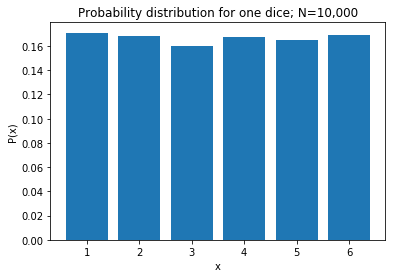

In [24]:
dice = Dice()
sides = [0] * dice.dices * dice.sides
N = 10000
for i in range(N): sides[dice.throw()-1] += 1
sides = np.array(sides) / N
bar(range(1,len(sides)+1), sides);
ylabel('P(x)')
xlabel('x')
title('Probability distribution for one dice; N=10,000');

### Advanced: two dice with six sides

Monopoly is played with two dices. This will the following probability distribution:

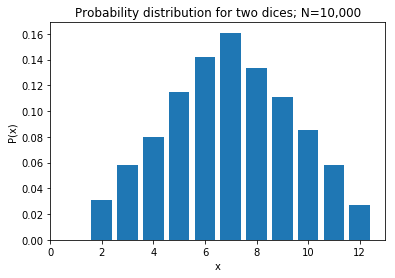

In [25]:
dice = Dice(2)
sides = [0] * dice.dices * dice.sides
N = 10000
for i in range(N): sides[dice.throw()-1] += 1
sides = np.array(sides) / N
bar(range(1,len(sides)+1), sides);
ylabel('P(x)')
xlabel('x')
title('Probability distribution for two dices; N=10,000');

## Monopoly simulation

We are playing a simplified version of Monopoly. We will not keep track of money. There will only be one player. If a player goes to jail, the player can continue immediately on the next turn. We will keep track of the card decks. The game will be played with $2$ dices. We only count when we land on a square. If we are moved to jail for example, the next round will continue from that new position.

### Algorithm

Here we are going to simulate a game for $N$ amount of rounds. The game algorithm is simple:

1. Roll the dices (there are $2$ dices with $6$ squares)
2. Move to the new position
3. Increment the square counter for that position
4. Check and handle go to jail
5. Check and handle community chest
6. Check and handle chance

### Modulo arithmetic for position tracking

We can easily keep track of our position with modulo arithemetic. Let $C$ be our position (or `index`), $d$ the result from throwing the dice, and $n$ the current round. To determine our new position we calculate:

$$ C_{n+1} \equiv C_n+d \pmod{40}$$

The modulo is $40$ because that are the total amount of squares.

### Implementation

Below is the implementation for the Monopoly simulation.

In [26]:
dice = Dice(2)
community_deck = CommunityDeck()
chance_deck = ChanceDeck()

index = 0 # position
total_squares = len(squares_labels)
squares = [0] * total_squares

rounds = 1000000 # N

for i in range(rounds):
    
    # Throw the dice and move our position on the board.
    steps = dice.throw()
    index = (index + steps) % total_squares
    
    # We landed on go to jail.
    if squares_labels[index] is 'gtj': 
        index = squares_labels.index('jail')
    
    # We landed on the community card.
    if squares_labels[index] in ['cc1', 'cc2', 'cc3']:
        card = community_deck.draw_card()
        if card is 'gtg': index = squares_labels.index('start')
        if card is 'gtj': index = squares_labels.index('jail')
        if card is 'gb2': 
            if index >= 2: index -= 2
            if index < 2: index = total_squares-abs(index-2)-1
    
    # We landed on the chance card.
    if squares_labels[index] in ['c1', 'c2', 'c3']:
        card = chance_deck.draw_card()
        if card is 'gtg': index = squares_labels.index('start')
        if card is 'gtj': index = squares_labels.index('jail')
        if card is 'r3': index = squares_labels.index('r3')
        if card is 'gb3':
            if index >= 3: index -= 3
            if index < 3: index = total_squares-abs(index-3)-1
                
    # Update the counter
    squares[index] += 1

It takes around $2.7$ seconds to run a game when $N=1,000,000$. Because there is only one loop the algorithm will scale linearly.

## Probability statistics

Now we can proceed to analyze our results.

### Determining probabilities

With the number of times that each square is visited, and the total rounds $N$ we can calculate the probabilities. The probability that a square is visited is:

$$ P(\bar{x}=x) = \dfrac{\text{Times visited}}{\text{N}} $$

We can calculate the expected value for each square in terms of money with:

$$ E(\bar{k}) = P(\bar{x}=x)\cdot\text{Rent} $$

We also want to create a `DataFrame` in Python to easily keep track of everything.

In [27]:
df = pd.DataFrame(index=range(total_squares))
df['Square'] = squares_labels
df['Description'] = squares_description
df['Purchasable'] = squares_purchasable
df['Rent'] = squares_rent
df['Visited'] = squares
df['Probability'] = df['Visited'] / rounds
df['Aggregate'] = squares_aggregate
df['Expected Value'] = df['Probability'] * df['Rent']

We can calculate a quick summary about the data:

In [28]:
print('Total rounds: {}'.format(rounds))
print('Visited avg:  {}'.format(df['Visited'].mean()))
print('Visited min:  {}'.format(df['Visited'].min()))
print('Visited max:  {}'.format(df['Visited'].max()))
print('Visited std:  {:.2f}'.format(df['Visited'].std()))

Total rounds: 1000000
Visited avg:  25000.0
Visited min:  0
Visited max:  59080
Visited std:  7543.78


### Plot of probabilities by square

If we sort these values descending on the probability, we can easily see which squares have the highest probability to be visited.

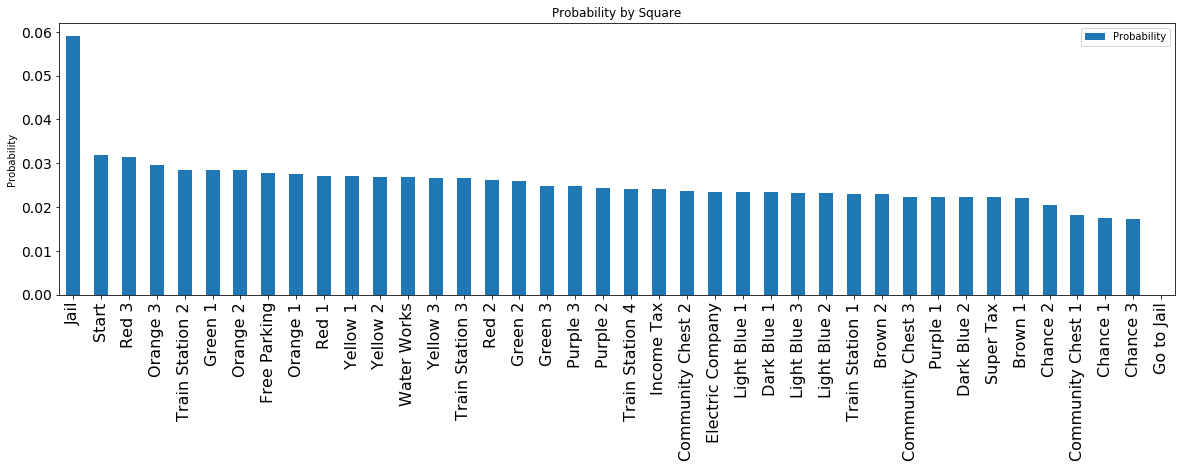

In [29]:
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=14) 
df[['Description', 'Probability']].sort_values(by='Probability', ascending=False)\
    .plot(kind='bar', figsize=(20,5))
plt.xticks(range(total_squares), df[['Description', 'Probability']]
    .sort_values(by='Probability', ascending=False)['Description'])
plt.ylabel('Probability')
plt.title('Probability by Square');

Here we can conclude that `Orange 1` is the most visited square. Also notice that `Orange 2` and `Orange 3` are pretty high. It seems that `Orange` is the best street to have.

### Table of probabilities by square

Below is the full table with all the squares and their corresponding values.

In [30]:
df.loc[:, df.columns.isin(['Square', 'Description', 'Probability'])].sort_values(by='Probability', ascending=False)

,Square,Description,Probability
10,jail,Jail,0.059080
0,start,Start,0.031799
24,r3,Red 3,0.031463
19,o3,Orange 3,0.029676
15,ts2,Train Station 2,0.028553
31,g1,Green 1,0.028538
18,o2,Orange 2,0.028437
20,p,Free Parking,0.027818
16,o1,Orange 1,0.027570
21,r1,Red 1,0.027186


### Top 10 highest probability squares

The top 10 squares that have the highest probability for a player to land on are:

In [31]:
df.loc[df['Purchasable'] == True, df.columns.isin(['Square', 'Description', 'Probability'])]\
    .sort_values('Probability', ascending=False).head(10)

,Square,Description,Probability
24,r3,Red 3,0.031463
19,o3,Orange 3,0.029676
15,ts2,Train Station 2,0.028553
31,g1,Green 1,0.028538
18,o2,Orange 2,0.028437
16,o1,Orange 1,0.027570
21,r1,Red 1,0.027186
26,y1,Yellow 1,0.027147
27,y2,Yellow 2,0.026920
28,ww,Water Works,0.026801


The total probability for all 10 squares is:

In [32]:
df.loc[df['Purchasable'] == True].sort_values('Probability', ascending=False)\
    .head(10)['Probability'].sum()

0.28229100000000001

### Plot of expected value per turn

Now we want to know how much each square generates per turn with the found probabilities and the rent the player needs to pay when we land on it. First we make a selection to only get the purchasable squares. 

In [33]:
rentable_df = pd.DataFrame(df.loc[df['Purchasable'] == True]).reindex()

Plotting this gives:

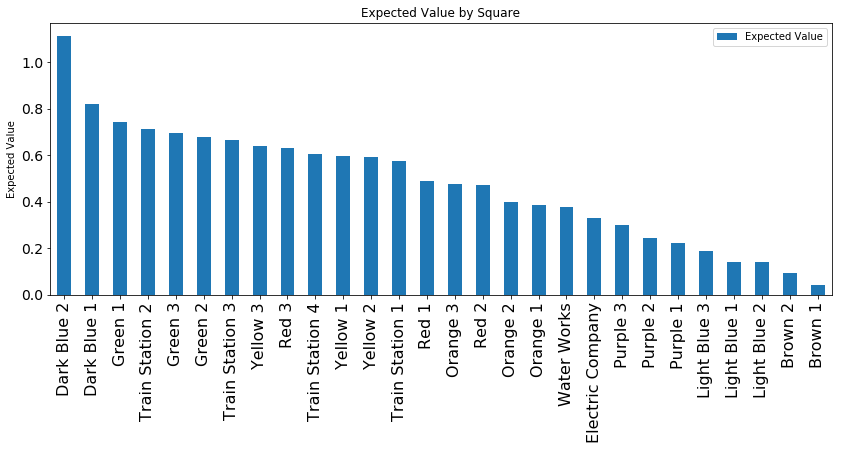

In [34]:
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=14) 
rentable_df[['Description', 'Expected Value']].sort_values(by='Expected Value', ascending=False)\
    .plot(kind='bar', figsize=(14,5))
plt.xticks(range(len(rentable_df.index)), rentable_df[['Description', 'Expected Value']]
    .sort_values(by='Expected Value', ascending=False)['Description'])
plt.ylabel('Expected Value')
plt.title('Expected Value by Square');

### Table of expected value per turn 

The full table of expected values is below.

In [35]:
rentable_df.loc[:, rentable_df.columns.isin(['Square', 'Description', 'Rent', 'Probability', 'Expected Value'])]\
    .sort_values('Expected Value', ascending=False)

,Square,Description,Rent,Probability,Expected Value
39,db2,Dark Blue 2,50.0,0.022233,1.111650
37,db1,Dark Blue 1,35.0,0.023376,0.818160
31,g1,Green 1,26.0,0.028538,0.741988
15,ts2,Train Station 2,25.0,0.028553,0.713825
34,g3,Green 3,28.0,0.024879,0.696612
32,g2,Green 2,26.0,0.026025,0.676650
25,ts3,Train Station 3,25.0,0.026621,0.665525
29,y3,Yellow 3,24.0,0.026641,0.639384
24,r3,Red 3,20.0,0.031463,0.629260
35,ts4,Train Station 4,25.0,0.024131,0.603275


## Grouped probability statistics

We want to answer the following questions:

1. What are the best streets to have?
2. What is the probability to be in jail?
3. What is the probability to draw a card?

### Plot of probabilities by group

To find what the probabilities are per street, chance, community chest, etc., we are going to aggregate the possibilities.

In [36]:
aggregated_df = pd.DataFrame(df.groupby(['Aggregate'])['Probability'].sum()).reset_index()

Now we plot the aggregated probabilities.

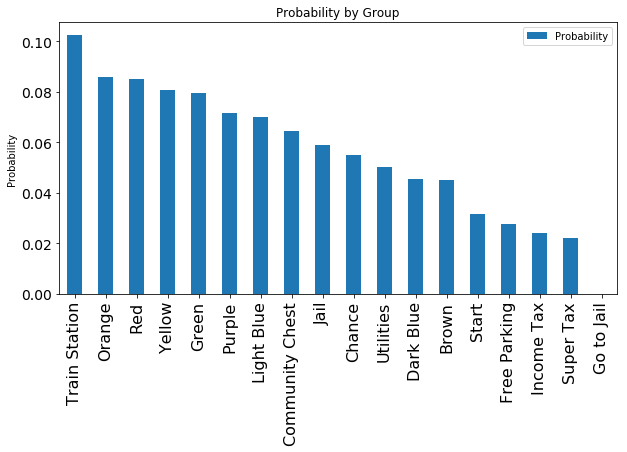

In [37]:
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=14) 
aggregated_df[['Aggregate', 'Probability']].sort_values(by='Probability', ascending=False)\
    .plot(kind='bar', figsize=(10,5))
plt.xticks(range(len(aggregated_df.index)), aggregated_df[['Aggregate', 'Probability']]
    .sort_values(by='Probability', ascending=False)['Aggregate'])
plt.ylabel('Probability')
plt.title('Probability by Group');

### Table of probabilities by group

A total overview of all the probabilities can be found in the table below:

In [38]:
aggregated_df.sort_values('Probability', ascending=False)

,Aggregate,Probability
15,Train Station,0.102338
10,Orange,0.085683
12,Red,0.084935
17,Yellow,0.080708
6,Green,0.079442
11,Purple,0.071483
9,Light Blue,0.070022
2,Community Chest,0.064408
8,Jail,0.059080
1,Chance,0.055026


### Plot of expected values by group

If we find the expected values by each aggregate we can find out which group generated the most money per turn.

In [39]:
aggregated_ev_df = pd.DataFrame(df.loc[df['Purchasable'] == True]\
    .groupby(['Aggregate'])['Expected Value'].sum()).reset_index()

Plotting this gives:

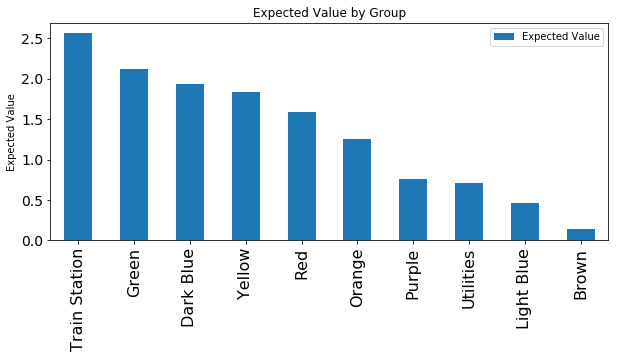

In [40]:
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=14) 
aggregated_ev_df[['Aggregate', 'Expected Value']].sort_values(by='Expected Value', ascending=False)\
    .plot(kind='bar', figsize=(10,4))
plt.xticks(range(len(aggregated_ev_df.index)), aggregated_ev_df[['Aggregate', 'Expected Value']]
    .sort_values(by='Expected Value', ascending=False)['Aggregate'])
plt.ylabel('Expected Value')
plt.title('Expected Value by Group');

We can conclude that the `Train Station` yields the most. This are however $4$ squares. The best street to have is `Green`.

### Table of expected values by group

A full table of expected values can be found below

In [41]:
aggregated_ev_df.sort_values('Expected Value', ascending=False)

,Aggregate,Expected Value
7,Train Station,2.558450
2,Green,2.115250
1,Dark Blue,1.929810
9,Yellow,1.828858
6,Red,1.591756
4,Orange,1.258914
5,Purple,0.764472
8,Utilities,0.704606
3,Light Blue,0.466710
0,Brown,0.135848


## Other probabilities

### Train station probabilities

We can conclude that `Train Station` has the highest probability to land on. However, we need to take into account that there are four squares to land on.

In [42]:
df.loc[df['Aggregate'] == 'Train Station', df.columns.isin(['Square', 'Description', 'Probability', 'Expected Value'])]\
    .sort_values('Probability', ascending=False)

,Square,Description,Probability,Expected Value
15,ts2,Train Station 2,0.028553,0.713825
25,ts3,Train Station 3,0.026621,0.665525
35,ts4,Train Station 4,0.024131,0.603275
5,t1,Train Station 1,0.023033,0.575825


### Probability to be in jail

To find the total probability to be in jail, we need to take into account that:

 * We can land on jail.
 * We can land on go to jail.
 * There is one community card which sends you to jail.
 * There is one chance card which sends you to jail.
 
Each deck has $16$ cards, therefore the probability to draw go to jail is $P(\bar{x}=\text{go to jail})=\dfrac{1}{16}$.

$$P(\bar{x}=\text{in jail}) = P(\bar{x}=\text{jail}) + P(\bar{x}=\text{go to jail}) + \dfrac{1}{16}\left[ P(\bar{x}=\text{community chest}) + P(\bar{x}=\text{chance})\right] $$

In [43]:
P_jail           = sum(aggregated_df.loc[aggregated_df['Aggregate'] == 'Jail'           ]['Probability'])
P_go_to_jail     = sum(aggregated_df.loc[aggregated_df['Aggregate'] == 'Go to Jail'     ]['Probability'])
P_community_card = sum(aggregated_df.loc[aggregated_df['Aggregate'] == 'Community Chest']['Probability'])
P_chance_card    = sum(aggregated_df.loc[aggregated_df['Aggregate'] == 'Chance'         ]['Probability'])

In [44]:
P_jail + P_go_to_jail + 1/16 * (P_community_card + P_chance_card)

0.066544624999999996

### Probability to draw a card

To find the probability to draw a card, we simply calculate:

$$ P(\bar{x}=\text{draw a card}) = P(\bar{x}=\text{community chest}) + P(\bar{x}=\text{chance})$$

In [45]:
P_community_card + P_chance_card

0.119434

Where the probabilities for the community chest square are:

In [46]:
df.loc[df['Aggregate'] == 'Community Chest', df.columns.isin(['Square', 'Description', 'Probability'])]\
    .sort_values('Probability', ascending=False)

,Square,Description,Probability
17,cc2,Community Chest 2,0.023753
33,cc3,Community Chest 3,0.022388
2,cc1,Community Chest 1,0.018267


And the probabilities for the chance square are:

In [47]:
df.loc[df['Aggregate'] == 'Chance', df.columns.isin(['Square', 'Description', 'Probability'])]\
    .sort_values('Probability', ascending=False)

,Square,Description,Probability
22,c2,Chance 2,0.020359
7,c1,Chance 1,0.017436
36,c3,Chance 3,0.017231


## Conclusion

We saw the expected values per turn for each square. Train stations are by far the best to buy. The multiplier for them is not taken into account here. Which means that the actual results are even better. After that, buying should be done in a priority. I wouldn't buy utilities, brown and light blue squares because they have a very low expected value.

### Top 10 streets

A table of the top 10 squares by expected value.

In [48]:
df.loc[:,df.columns.isin(['Square', 'Description', 'Probability', 'Expected Value'])]\
    .sort_values('Expected Value', ascending=False).head(10)

,Square,Description,Probability,Expected Value
39,db2,Dark Blue 2,0.022233,1.111650
37,db1,Dark Blue 1,0.023376,0.818160
31,g1,Green 1,0.028538,0.741988
15,ts2,Train Station 2,0.028553,0.713825
34,g3,Green 3,0.024879,0.696612
32,g2,Green 2,0.026025,0.676650
25,ts3,Train Station 3,0.026621,0.665525
29,y3,Yellow 3,0.026641,0.639384
24,r3,Red 3,0.031463,0.629260
35,ts4,Train Station 4,0.024131,0.603275


### Top 10 groups

A table of the top 10 groups by expected value.

In [49]:
aggregated_ev_df.sort_values('Expected Value', ascending=False).head(10)

,Aggregate,Expected Value
7,Train Station,2.558450
2,Green,2.115250
1,Dark Blue,1.929810
9,Yellow,1.828858
6,Red,1.591756
4,Orange,1.258914
5,Purple,0.764472
8,Utilities,0.704606
3,Light Blue,0.466710
0,Brown,0.135848


#### Additional note about train stations

Notice that if you own all $4$ train stations, any visitor has to pay $\$200$ instead of the $\$25$ for owning one. From this we can find that the expected value is multiplied by $8$, if you own them all.

In [50]:
8 * df.loc[df['Aggregate'] == 'Train Station']['Expected Value'].sum()

20.467599999999997

And for $3$ train stations, any visitor has to pay $\$100$, which multiplied by $4$ gives:

In [51]:
4 * df.loc[df['Aggregate'] == 'Train Station']['Expected Value'].sum()

10.233799999999999

Finally for $2$ train stations, any visitor has to pay $\$50$, which multiplied by $2$ gives:

In [52]:
2 * df.loc[df['Aggregate'] == 'Train Station']['Expected Value'].sum()

5.1168999999999993

Now keep in mind that if you own the **entire** best street, the results are:

In [53]:
aggregated_ev_df.sort_values('Expected Value', ascending=False).iloc[[1,2,3]]

,Aggregate,Expected Value
2,Green,2.115250
1,Dark Blue,1.929810
9,Yellow,1.828858


### Probability to go to jail

The probability to go to jail is:

In [54]:
P_jail + P_go_to_jail + 1/16 * (P_community_card + P_chance_card)

0.066544624999999996

### Probability to draw a card

The probability to draw a card is:

In [55]:
P_community_card + P_chance_card

0.119434

## Markov matrix

Another way to find the probabilities, would be to create a Markov matrix with the probability to go another square, for each individual square. This will be a $40\times40$ square matrix $M$.

In [56]:
M = np.eye(40)

In [57]:
M

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

Then we need to fill in the matrix. For each square we are going to calculate the probabilities to get on any other square. For the most the probability will be $0$ because we can't throw high enough numbers. We also need to take into the account that there are probabilities that are generated by the cards and add those to the respecting elements.

When we have filled the matrix with all the values we let the matrix converge with $\lim\limits_{T\rightarrow\infty}A^T$. A simple way to approximate this would be to square the matrix a few times, like $M^{25}$. The resulting matrix will have the probabilities for every square.

Because this is a Markov matrix, a more rigirous way of doing it would be calculate the eigenvectors and eigenvalues for the matrix. With the eigenvector we can find the stable state for the system where $p(n)\cdot A=p(n)$. Where $p(n)$ holds the probabilities to get on each tile. 

### Markov matrix example

A simple example with a markov matrix. We can find the stable system with the eigenvectors and eigenvalues of a markov matrix. The solution is a stable system. This means that the probability for each element is converged.

Let $A=\begin{bmatrix}0.8 & 0.3 \\ 0.2 & 0.7\end{bmatrix}$.

In [58]:
from numpy import linalg as la
A = np.array([0.8, 0.3, 0.2, 0.7]).reshape(2,2)
A

array([[ 0.8,  0.3],
       [ 0.2,  0.7]])

We get the eigenvalues $w$ and eigenvectors $v$.

In [59]:
w, v = la.eig(A)

Now if we approximate that $A$ converges to the stable state.

In [60]:
z=A
for _ in range(26): z = np.dot(A,z)
A=z
A

array([[ 0.6,  0.6],
       [ 0.4,  0.4]])

Create $p(0)=\begin{bmatrix}600\\400\end{bmatrix}$ which is an eigenvector for eigenvalue $1$.

In [61]:
p0 = np.array([600,400]).reshape(2,1)
p0

array([[600],
       [400]])

We check that $A\cdot p(0) = p(0)$, it should give the same value back because it is an eigenvector.

In [62]:
np.dot(A,p0)

array([[ 600.],
       [ 400.]])

Which it does.

To get the stable solution from the eigenvectors we need to transpose $\vec{v}$... because `numpy` is weird.

In [63]:
v = v.T[0]

We are using the eigen vector $\vec{v}$ for eigen value $w=1$.

In [64]:
v

array([ 0.83205029,  0.5547002 ])

To find the stable state we multiply the eigenvalue $w=1$ with the corresponding eigen vector $\begin{bmatrix}v_1\\ v_2\end{bmatrix}$.

To normalize the result so that the sum of the elements in $\vec{v}$ is $1$ we divide the elements in $\vec{v}$ by the sum of the values in $\vec{v}$.

$$ \vec{s} = w \cdot \dfrac{1}{\sum\limits_{v \in \vec{v}}v} \cdot \begin{bmatrix} v_1 \\ v_2 \end{bmatrix} $$

Notice that $w=1$, so it becomes:

$$ \vec{s} = \dfrac{1}{\sum\limits_{v \in \vec{v}}v} \cdot \begin{bmatrix} v_1 \\ v_2 \end{bmatrix} $$

In [65]:
s = (v / sum(v)).reshape(2,1)
s

array([[ 0.6],
       [ 0.4]])

And to verify it is correct we check that $A\cdot \vec{s} = \vec{s}$:

In [66]:
np.dot(A,s)

array([[ 0.6],
       [ 0.4]])

Which is correct.

### Probabilities for throwing two dices

To fill our matrix $M$ we first need to find the probability distribution for two dices.

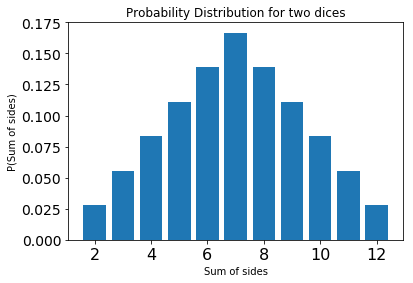

In [76]:
outcomes = [x+y for x in range(1,7) for y in range(1,7)]
probabilities = {}
for o in set(outcomes): probabilities[o] = outcomes.count(o) / len(outcomes)
side, p = probabilities.keys(), probabilities.values()
bar(side, p)
xlabel('Sum of sides')
ylabel('P(Sum of sides)')
title('Probability Distribution for two dices');

The range of values for two dices is:

In [77]:
throw_min = min(side)
throw_max = max(side)
throw_range = throw_max - throw_min
print('Outcomes are min: {}, max: {} and range: {}.'.format(throw_min, throw_max, throw_range))
prob_df = pd.DataFrame()
prob_df['Sum of sides'] = side
prob_df['P(Sum of sides)'] = p

Outcomes are min: 2, max: 12 and range: 10.


In [78]:
prob_df

,Sum of sides,P(Sum of sides)
0,2,0.027778
1,3,0.055556
2,4,0.083333
3,5,0.111111
4,6,0.138889
5,7,0.166667
6,8,0.138889
7,9,0.111111
8,10,0.083333
9,11,0.055556


In [79]:
squares_labels.index('r3')

24

In [113]:
def get_probability_for_throw(n):
    if n < 2 or n > 12: return 0
    return probabilities[n]

def get_probabilities_for_position(pos):
    squares = [0] * 40
    for i in range(40):
        squares[(pos+i)%40] = get_probability_for_throw(i)
    
    # Go to jail
    squares[10] += squares[2] * 1/16  # Go to jail community card 1
    squares[10] += squares[7] * 1/16  # Go to jail chance card 1
    squares[10] += squares[17] * 1/16 # Go to jail community card 2
    squares[10] += squares[22] * 1/16 # Go to jail chance card 2
    squares[10] += squares[33] * 1/16 # Go to jail community card 3
    squares[10] += squares[36] * 1/16 # Go to jail chance card 3
    
    # Go to start
    squares[0] += squares[2] * 1/16   # Go to start community card 1
    squares[0] += squares[7] * 1/16   # Go to start chance card 1
    squares[0] += squares[17] * 1/16  # Go to start community card 2
    squares[0] += squares[22] * 1/16  # Go to start chance card 2
    squares[0] += squares[33] * 1/16  # Go to start community card 3
    squares[0] += squares[36] * 1/16  # Go to start chance card 3
    
    # Go back 2
    squares[0] += squares[2] * 1/16   # Go back 2 community card 1
    squares[15] += squares[17] * 1/16 # Go back 2 community card 2
    squares[31] += squares[33] * 1/16 # Go back 2 community card 3
    
    # Go back 3
    squares[4] += squares[7] * 1/16   # Go back 3 chance card 1
    squares[19] += squares[22] * 1/16 # Go back 3 chance card 2
    squares[33] += squares[36] * 1/16 # Go back 3 chance card 3
    
    # Go to r3
    squares[24] += squares[7] * 1/16   # Go back 3 chance card 1
    squares[24] += squares[22] * 1/16 # Go back 3 chance card 2
    squares[24] += squares[36] * 1/16 # Go back 3 chance card 3    
    
    return squares

In [122]:
get_probabilities_for_position(32)

[0.15451388888888892,
 0.1111111111111111,
 0.08333333333333333,
 0.05555555555555555,
 0.027777777777777776,
 0,
 0,
 0,
 0,
 0,
 0.010416666666666666,
 0,
 0,
 0,
 0,
 0.0,
 0,
 0,
 0,
 0.0,
 0,
 0,
 0,
 0,
 0.005208333333333333,
 0,
 0,
 0,
 0,
 0,
 0,
 0.0,
 0,
 0.005208333333333333,
 0.027777777777777776,
 0.05555555555555555,
 0.08333333333333333,
 0.1111111111111111,
 0.1388888888888889,
 0.16666666666666666]

In [116]:
chances = []
for p in range(40): chances += get_probabilities_for_position(p)

In [117]:
len(chances)

1600

In [127]:
M = np.array(chances).reshape(40,40)

In [128]:
w,v = la.eig(M)

In [131]:
len(w)

40

In [130]:
v

array([[-0.15876214+0.j        , -0.04667722+0.15107303j,
        -0.04667722-0.15107303j, ..., -0.09858166+0.12357599j,
        -0.09858166-0.12357599j,  0.15807719+0.j        ],
       [-0.15728901+0.j        , -0.06952682+0.14101409j,
        -0.06952682-0.14101409j, ..., -0.06400858-0.14474662j,
        -0.06400858+0.14474662j, -0.15807719+0.j        ],
       [-0.15667880+0.j        , -0.09045292+0.12811203j,
        -0.09045292-0.12811203j, ...,  0.17657180+0.j        ,
         0.17657180-0.j        ,  0.12843772+0.j        ],
       ..., 
       [-0.15766690+0.j        ,  0.02657668+0.15660917j,
         0.02657668-0.15660917j, ..., -0.11675417+0.10454904j,
        -0.11675417-0.10454904j, -0.15807719+0.j        ],
       [-0.15785947+0.j        ,  0.00193865+0.15852121j,
         0.00193865-0.15852121j, ..., -0.03993390-0.15249195j,
        -0.03993390+0.15249195j,  0.15807719+0.j        ],
       [-0.15821763+0.j        , -0.02267960+0.15666897j,
        -0.02267960-0.1566689

In [132]:
v = v.T[0]

In [138]:
z = (w[0] * (v / sum(v))).reshape(40,1)

In [139]:
df2 = pd.DataFrame()
df2['Street'] = squares_description
df2['P'] = z

In [142]:
df2.sort_values('P', ascending=False)

,Street,P
29,Yellow 3,(0.0263916744324+0j)
28,Water Works,(0.0263631811164+0j)
26,Yellow 1,(0.0263625129092+0j)
27,Yellow 2,(0.026350196292+0j)
30,Go to Jail,(0.0262111553694+0j)
25,Train Station 3,(0.0261304307087+0j)
15,Train Station 2,(0.0261085574301+0j)
31,Green 1,(0.0260313028735+0j)
14,Purple 3,(0.0260140923045+0j)
13,Purple 2,(0.0259584388317+0j)
